# Optimizer

## LandUse optimizer

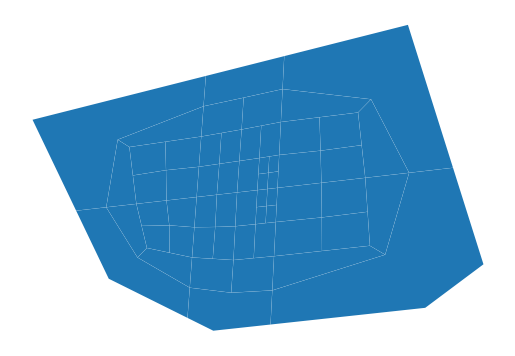

In [1]:
import geopandas as gpd

blocks_gdf = gpd.read_file('sveto.geojson')[['geometry']]
blocks_gdf.geometry = blocks_gdf.buffer(-0.5)
blocks_gdf = gpd.GeoDataFrame(blocks_gdf.geometry.explode(True)).reset_index(drop=True)
blocks_gdf.plot().set_axis_off()

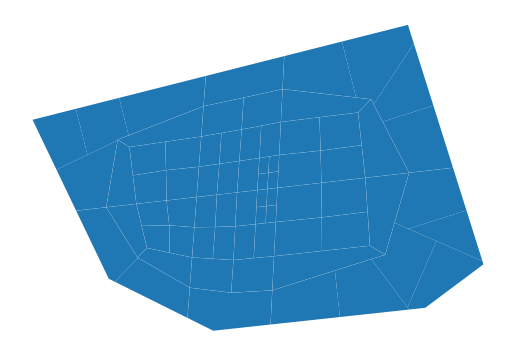

In [2]:
from blocksnet.preprocessing import LandUseOptimizer
import networkx as nx

luo = LandUseOptimizer(blocks_gdf)
luo.blocks.plot().set_axis_off()

In [10]:
from blocksnet import LandUse

lu_shares = {
  LandUse.RESIDENTIAL: 0.5,
  LandUse.BUSINESS: 0.1,
  LandUse.RECREATION: 0.3,
  LandUse.SPECIAL: 0.05,
  LandUse.INDUSTRIAL: 0.00,
  LandUse.AGRICULTURE: 0.00,
  LandUse.TRANSPORT: 0.05
}

best_X, best_value, Xs, values = luo.run(lu_shares, rate=0.999, max_iter=100_000)

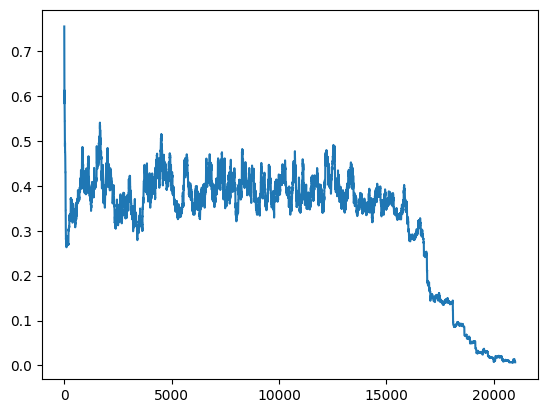

In [11]:
import matplotlib.pyplot as plt

plt.plot(values)

In [24]:
best_value

0.006642919370377889

In [25]:
luo.to_shares_dict(best_X)

{<LandUse.RESIDENTIAL: 'residential'>: 0.42676413957293213,
 <LandUse.BUSINESS: 'business'>: 0.1034966305168017,
 <LandUse.RECREATION: 'recreation'>: 0.31391408708272217,
 <LandUse.SPECIAL: 'special'>: 0.06639987300850723,
 <LandUse.INDUSTRIAL: 'industrial'>: 0.023418582070743696,
 <LandUse.AGRICULTURE: 'agriculture'>: 7.385198149101603e-14,
 <LandUse.TRANSPORT: 'transport'>: 0.06600668774821938}

In [12]:
data = [{lu.value : share for lu,share in luo.to_shares_dict(X).items()} for X in Xs]

<Axes: >

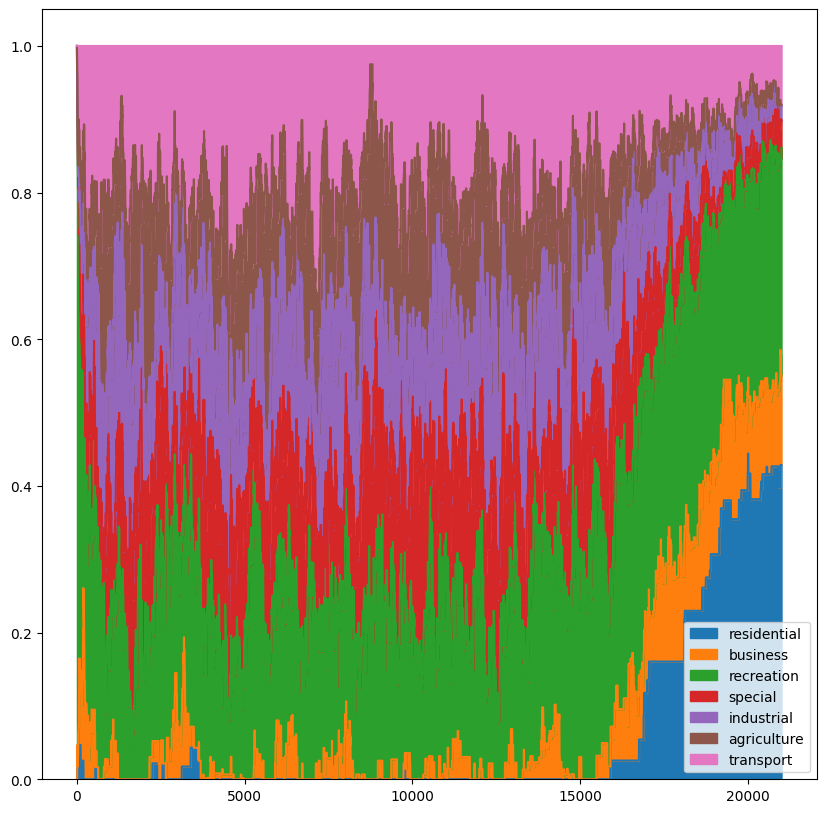

In [13]:
import pandas as pd

df = pd.DataFrame(data)
df.plot(kind='area', stacked=True, figsize=(10,10))

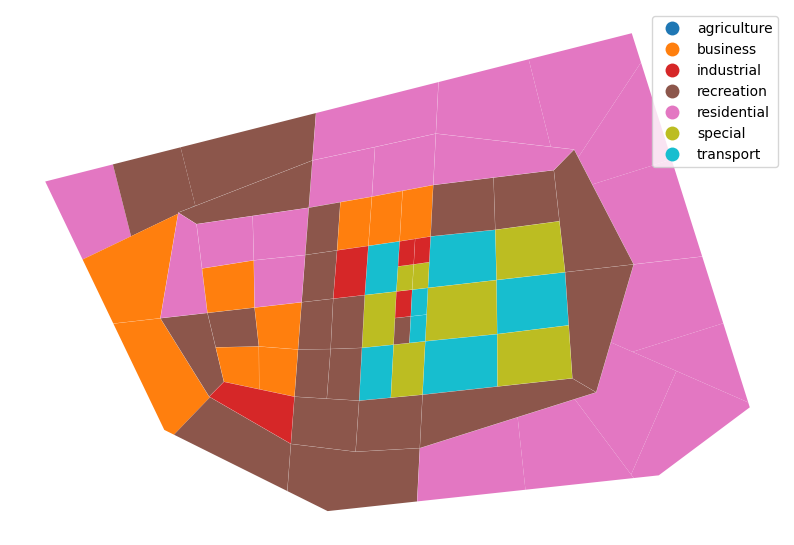

In [14]:
luo.to_gdf(best_X).plot(column='land_use', legend=True, figsize=(10,10)).set_axis_off()

In [23]:
all(luo.blocks.area>=2_000)

False

## Services optimizer

In [54]:
import networkx as nx
from blocksnet import AccessibilityProcessor
from shapely import length, LineString, Point

SPEED = 10 * 1000 / 60

graph = luo.adjacency_graph.copy()
graph.graph['crs'] = luo.blocks.crs.to_epsg()
for node, data in graph.nodes(data=True):
  point = luo.blocks.loc[node,'geometry'].representative_point()
  data['geometry'] = point
  data['x'] = point.x
  data['y'] = point.y
for u, v, data in graph.edges(data=True):
  point_u = graph.nodes[u]['geometry']
  point_v = graph.nodes[v]['geometry']
  line_string = LineString([point_u, point_v])
  data['time_min'] = length(line_string)/SPEED

ap = AccessibilityProcessor(luo.blocks)
acc_mx = ap.get_accessibility_matrix(graph)

In [58]:
from blocksnet import City

city = City(luo.to_gdf(best_X), acc_mx)

 30%|███       | 3038/10000 [04:40<10:43, 10.81it/s]


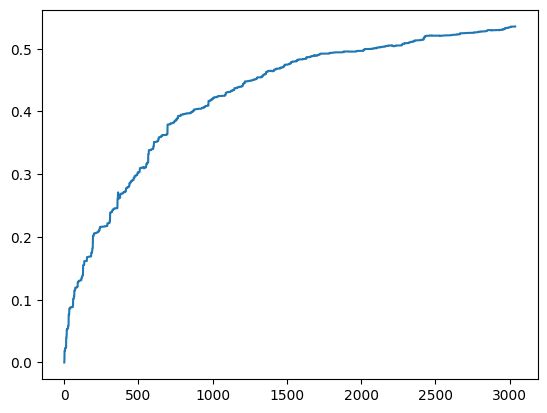

In [64]:
from blocksnet.method.annealing_optimizer import AnnealingOptimizer, LU_INDICATORS

blocks_lu = {block.id : best_X[block.id] for block in city.blocks}
blocks_fsi = {b_id : LU_INDICATORS[lu].fsi_min for b_id, lu in blocks_lu.items()}
blocks_gsi = {b_id : LU_INDICATORS[lu].gsi_min for b_id, lu in blocks_lu.items()}
service_types = {service_type.name : 1/len(city.service_types) for service_type in city.service_types}

values = []

def on_iteration(i, X, indicators, value):
    values.append(value)

ao = AnnealingOptimizer(city_model=city, on_iteration=on_iteration, verbose=True)
X, indicators, value, provisions = ao.calculate(blocks_lu, blocks_fsi, blocks_gsi, service_types, rate=0.99, max_iter=10_000)

plt.plot(values)